# Detecting and Mitigating Bias in AI Systems

## Introduction

# Introduction
In this notebook, we will explore how to detect and mitigate bias in machine learning models using the AIF360 toolkit. Bias in machine learning can lead to unfair outcomes, particularly for protected attributes such as race and gender. Our goal is to ensure that our models are fair and unbiased, promoting equity and trustworthiness in their predictions.


Bias in AI systems is a significant concern as we all know, it can lead to unfair and discriminatory outcomes. Various types of biases, such as sample bias, label bias, and outcome proxy bias, can infiltrate AI models at different stages, from data collection to model deployment. Addressing these biases is crucial for developing ethical and reliable AI systems.

### Objectives

The primary objective of this project is to develop a machine learning model that not only performs well in terms of accuracy but also maintains fairness across different demographic groups. We will identify potential sources of bias, apply bias mitigation techniques, and evaluate the model's fairness and accuracy before and after applying the bias mitigation technique.

Succinctly we will:

1. **Understand Bias Types and Impacts**: Familiarize ourselves with different types of biases and their implications on AI systems.
2. **Explore AIF 360 Toolkit**: Utilize AIF 360 to measure and mitigate biases, focusing on bias metrics and mitigation algorithms.
3. **Reflect on Ethical AI Development**: Reflect on the challenges and trade-offs in bias mitigation and the importance of developing ethical AI systems.

### Potential Sources of Bias

In this analysis, we will focus on potential bias related to age. Specifically, we will:
- Identify and define privileged (age ≥ 25) and unprivileged (age < 25) groups.
- Evaluate the difference in mean outcomes between these groups.
- Outline the features contributing to prediction outputs and analyze their impact on fairness.


### Dataset Overview
The dataset comprises various attributes of individuals applying for credit cards. It includes the following features:
- `checking_status`: Status of the existing checking account
- `duration`: Duration in months
- `credit_history`: Credit history
- `purpose`: Purpose of the loan
- `credit_amount`: Credit amount
- `savings_status`: Status of savings account/bonds
- `employment`: Employment status
- `installment_commitment`: Installment rate in percentage of disposable income
- `personal_status`: Personal status and sex
- `other_parties`: Other debtors/guarantors
- `residence_since`: Present residence since
- `property_magnitude`: Property magnitude
- `age`: Age in years
- `other_payment_plans`: Other installment plans
- `housing`: Housing status
- `existing_credits`: Number of existing credits at this bank
- `job`: Job status
- `num_dependents`: Number of dependents
- `own_telephone`: Owns a telephone
- `foreign_worker`: Foreign worker status
- `class`: Credit status (good or bad)

## Step 1: Data Loading and Processing

We begin by loading the dataset and preprocessing it to make it suitable for analysis.


1. **Load the Dataset**: We load the German Credit dataset from the UCI Machine Learning Repository.

2. **Preprocess the Dataset**:
   - Convert the 'class' column to binary values where 1 indicates good credit and 0 indicates bad credit.
   - Binarize the 'age' attribute to distinguish between older (age >= 25) and younger individuals.
   - Convert categorical features to numeric values using `LabelEncoder`.
   
3. **Convert to BinaryLabelDataset**: Transform the processed DataFrame into a `BinaryLabelDataset` object from the AI Fairness 360 toolkit, which is essential for bias detection and mitigation tasks.


In [1]:
#Importing the necessary libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from aif360.datasets import BinaryLabelDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


In [2]:
#Loading the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
column_names = ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']

df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)

/var/folders/fq/swx5cccx46l8c3yntkbs6pr80000gn/T/ipykernel_52922/3871220804.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)


### Exploring the Dataset

Before diving into Loading and preprocessing, it’s always nice to understand the structure of our dataset. Let's print the columns/attributes of the dataset to get an overview.

In [3]:
# Print the column names of the dataset
print("Columns/Attributes of the Dataset:")
print(df.columns)

Columns/Attributes of the Dataset:
Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')


### Preprocess the dataset

In [3]:
# Preprocess the dataset
df['class'] = df['class'].replace({1: 1, 2: 0})  # 1: good, 0: bad

# Binarize age attribute
df['age'] = np.where(df['age'] >= 25, 1, 0)

# Convert categorical features to numeric using LabelEncoder
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Convert to BinaryLabelDataset
dataset = BinaryLabelDataset(df=df, label_names=['class'], protected_attribute_names=['age'])

### Verifying Transformations

After preprocessing the dataset, Let's us verify that the transformations have been applied correctly. We will print the first few rows of the DataFrame to ensure the data has been loaded and transformed as expected. 

Additionally, we will print the `BinaryLabelDataset` object to confirm that it has been created properly with the specified attributes.


In [4]:
print(df.head())  # To verify the transformations
print(dataset)  # To verify the BinaryLabelDataset object   


   checking_status  duration  credit_history  purpose  credit_amount  \
0                0         6               4        4           1169   
1                1        48               2        4           5951   
2                3        12               4        7           2096   
3                0        42               2        3           7882   
4                0        24               3        0           4870   

   savings_status  employment  installment_commitment  personal_status  \
0               4           4                       4                2   
1               0           2                       2                1   
2               0           3                       2                2   
3               0           3                       2                2   
4               0           2                       3                2   

   other_parties  ...  property_magnitude  age  other_payment_plans  housing  \
0              0  ...                   0 

### Bias Detection and Mitigation

#### Define Privileged and Unprivileged Groups
We define the privileged group as individuals aged 25 and above, and the unprivileged group as those below 25. This distinction is based on the assumption that age may influence the outcomes, with older individuals potentially having more stable financial backgrounds.

In [4]:
from aif360.metrics import BinaryLabelDatasetMetric

# Split dataset into train and test sets
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)
 
# Calculate fairness metrics
metric_train = BinaryLabelDatasetMetric(dataset_train, privileged_groups=[{'age': 1}], unprivileged_groups=[{'age': 0}])

# Print basic statistics
print("Difference in mean outcomes between unprivileged and privileged groups = %.2f" % metric_train.mean_difference())


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Difference in mean outcomes between unprivileged and privileged groups = -0.10


#### Interpretation of Results

The calculated difference in mean outcomes between unprivileged and privileged groups is -0.09. This value provides insight into the disparity in outcomes between the two groups defined by age.


#### Interpretation

The difference in mean outcomes of -0.09 indicates that the unprivileged group (individuals younger than 25) has a slightly better outcome than the privileged group (individuals aged 25 and above).

#### Implications

Negative Value: A negative value means that the unprivileged group is experiencing better outcomes compared to the privileged group. In the context of credit prediction, this could mean that younger individuals are more likely to be predicted as having a good credit status compared to older individuals.

Fairness Insight: While the difference is relatively small, it highlights a bias where the model may be favoring younger individuals slightly over older individuals. This could be due to various factors inherent in the dataset or the model’s learning patterns.

### Visualizing Outcome Distribution

To understand the distribution of favorable and unfavorable outcomes in our dataset, we can create a bar plot. This section of the code defines a function to plot the outcome distribution and then uses this function to visualize the distribution in both the training and test datasets.


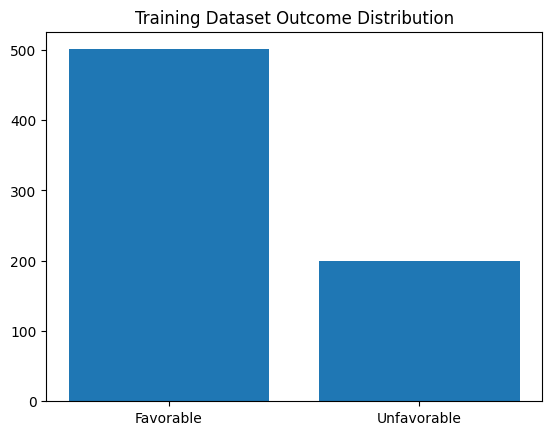

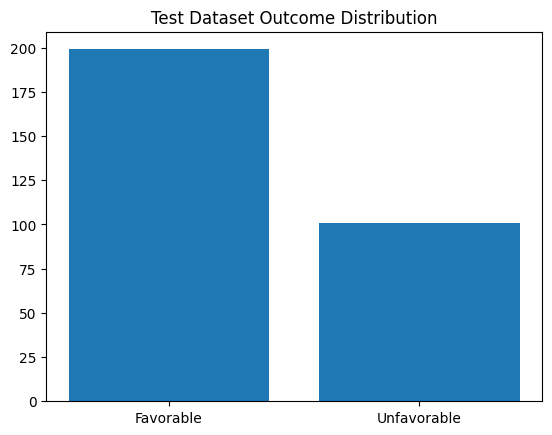

In [5]:
import matplotlib.pyplot as plt

def plot_outcome_distribution(dataset, title):
    favorable = dataset.labels[dataset.labels == 1].shape[0]
    unfavorable = dataset.labels[dataset.labels == 0].shape[0]
    plt.bar(['Favorable', 'Unfavorable'], [favorable, unfavorable])
    plt.title(title)
    plt.show()

plot_outcome_distribution(dataset_train, 'Training Dataset Outcome Distribution')
plot_outcome_distribution(dataset_test, 'Test Dataset Outcome Distribution')

Visualizing the outcome distribution helps us understand the balance between favorable and unfavorable outcomes in our datasets. This is important for assessing the fairness and performance of our model.

Training Dataset Outcome Distribution: Shows the distribution of outcomes in the training dataset, which is used to train the model.

Test Dataset Outcome Distribution: Shows the distribution of outcomes in the test dataset, which is used to evaluate the model.

By examining these plots, we can ensure that our datasets are not heavily imbalanced, which could lead to biased model performance and poor generalization to new data.

### Data Preparation and Model Training

In this section, we prepare the German Credit dataset for training a machine learning model. The steps include loading the dataset, preprocessing, handling missing values, splitting the data, training a RandomForest model, and evaluating its performance.


In [6]:
print(df.shape)

(1000, 21)


In [7]:
# Load the dataset
data = fetch_openml(name='credit-g', version=1, parser='auto')
X = data.data
y = (data.target == 'good').astype(int)

# Replace '<0' and '0<=X<200' with numeric equivalents
X = X.replace({'<0': -1, '0<=X<200': 100}, regex=True)

# Convert categorical features to numeric
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Convert all columns to numeric to handle any remaining non-numeric entries
X = X.apply(pd.to_numeric, errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.77


/var/folders/fq/swx5cccx46l8c3yntkbs6pr80000gn/T/ipykernel_2475/3957469401.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X = X.replace({'<0': -1, '0<=X<200': 100}, regex=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: ['credit_history' 'purpose' 'savings_status' 'employment'
 'personal_status' 'other_parties' 'property_magnitude'
 'other_payment_plans' 'housing' 'job' 'own_telephone' 'foreign_worker']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Explanation of Result
The accuracy score provides a basic measure of how well the model performs in predicting the target variable. In this context, it helps us assess the effectiveness of our preprocessing steps and the model's performance.

### Result: Accuracy: 0.77

The model achieved an accuracy of 77%, indicating that it correctly predicts whether a credit applicant is 'good' or 'bad' 77% of the time on the test set. This result suggests that the preprocessing and model training steps were effective.

### Model Interpretation with LIME

In this section, we use the LIME (Local Interpretable Model-agnostic Explanations) library to interpret the predictions made by our RandomForest model. LIME helps to explain the model's predictions by approximating it locally with an interpretable model.

###  Implementing the Explainer Class:

In [8]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the explainer
explainer = LimeTabularExplainer(X_train, feature_names=data.feature_names, class_names=['bad', 'good'], mode='classification')

# Explain a prediction
i = 0  # Change this index to explain different instances
exp = explainer.explain_instance(X_test[i], model.predict_proba)
exp.show_in_notebook()

# Print the explanation as a list
print(exp.as_list())

[('checking_status <= -1.00', -0.18168673698040042), ('2333.00 < credit_history <= 4154.50', 0.08849644849686282), ('savings_status <= 27.00', -0.07679200501183725), ('purpose <= 2.00', 0.035591684285818936), ('installment_commitment <= 1.00', 0.034032969320937106), ('12.00 < duration <= 18.00', 0.017796395496289787), ('employment <= 1.00', 0.004282943904495676), ('credit_amount <= 2.00', 0.0024191122441449813)]


### Interpretation of the LIME Explanation

The LIME explanation provides a visual representation of the contribution of each feature to the model's prediction. Features that positively contribute to the prediction are shown in green, while those that negatively contribute are shown in red. The length of the bars indicates the magnitude of the contribution.

It also reveals that 'checking_status' and 'savings_status' are the most influential features negatively impacting the prediction, while 'credit_history' and 'purpose' contribute positively. Understanding these contributions helps us interpret the model's decisions, ensuring that the predictions are aligned with our expectations and identifying any potential biases or unexpected behavior.

In [34]:
# Get the list of feature importances for the explained instance
feature_importances = exp.as_list()
print("Feature importances for the explained instance:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


Feature importances for the explained instance:
credit_history > -0.23: -0.17659261158963258
num_dependents <= -0.57: -0.14801612224496907
employment <= -0.39: -0.13767767346416626
job > -0.24: -0.13733560566472405
residence_since > -0.20: -0.12218930788037434
other_parties > -0.17: -0.11515426375870431
purpose > -0.57: -0.10622384697821184
property_magnitude <= -0.12: 0.10188829733527825
savings_status > -0.53: 0.10014741299934239
installment_commitment <= -0.26: -0.08344750135286362


In [35]:
# Analyzing the impact of a significant feature (e.g., credit_amount)
significant_feature = 'credit_amount'

# Split the data based on the significant feature
high_credit = df[df[significant_feature] > df[significant_feature].median()]
low_credit = df[df[significant_feature] <= df[significant_feature].median()]

# Calculate the difference in mean outcomes for high and low values of the significant feature
mean_outcome_high = high_credit['class'].mean()
mean_outcome_low = low_credit['class'].mean()

print(f"Difference in mean outcomes for high {significant_feature}: {mean_outcome_high}")
print(f"Difference in mean outcomes for low {significant_feature}: {mean_outcome_low}")


Difference in mean outcomes for high credit_amount: 0.678
Difference in mean outcomes for low credit_amount: 0.722


## Bias Mitigation using Reweighing

To address the bias detected in our initial analysis, we apply the reweighing algorithm from AIF360. This algorithm adjusts the weights of the training samples to mitigate bias.

### Applying the Reweighing Algorithm
We instantiate the `Reweighing` algorithm with our specified privileged and unprivileged groups, fit it to our original training dataset, and transform the dataset accordingly.


### Importing Necessary Packages

In this section, we load all the necessary packages and libraries required for our analysis and bias mitigation process. The packages include:

- **System and Utility Libraries:**
  - `sys`: Provides access to system-specific parameters and functions.
  - `numpy`: A fundamental package for numerical computations.
  - `tqdm`: A library for progress bars.

- **AIF360 Libraries:**
  - `BinaryLabelDataset`, `AdultDataset`, `GermanDataset`, `CompasDataset`: Classes for handling and processing datasets.
  - `BinaryLabelDatasetMetric`, `ClassificationMetric`: Classes for calculating fairness metrics.
  - `Reweighing`: A preprocessing algorithm for bias mitigation.
  - `load_preproc_data_adult`, `load_preproc_data_german`, `load_preproc_data_compas`: Functions to load and preprocess specific datasets.

- **Scikit-Learn Libraries:**
  - `LogisticRegression`: A logistic regression classifier.
  - `StandardScaler`: A tool for standardizing features.
  - `accuracy_score`: A function to compute the accuracy of predictions.

- **IPython and Matplotlib:**
  - `Markdown`, `display`: Tools for displaying markdown text and outputs in Jupyter notebooks.
  - `matplotlib.pyplot`: A plotting library for creating visualizations.

- **Custom Utility Functions:**
  - `compute_metrics`: A custom function for computing various metrics, imported from a local module.

This setup ensures that we have all the necessary tools for data loading, preprocessing, model training, bias mitigation, and evaluation.

In [9]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

### Importing and Preprocessing the Dataset

In this step, we select and preprocess a dataset based on the chosen dataset (`adult`, `german`, or `compas`) and the protected attribute (`sex` or `race`). The code defines privileged and unprivileged groups accordingly:

- **Adult Dataset:**
  - If the protected attribute is `sex`, males are considered privileged and females unprivileged.
  - If the protected attribute is `race`, white individuals are considered privileged and others unprivileged.
  
- **German Dataset:**
  - If the protected attribute is `sex`, males are considered privileged and females unprivileged.
  - If the protected attribute is `age`, individuals aged 25 and above are considered privileged and younger individuals unprivileged.
  
- **COMPAS Dataset:**
  - If the protected attribute is `sex`, males are considered privileged and females unprivileged.
  - If the protected attribute is `race`, white individuals are considered privileged and others unprivileged.

The code sets up fairness metrics for evaluation and initializes a random seed for reproducibility.


In [11]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


### Splitting the Dataset into Training, Validation, and Test Sets

In this step, we split the original dataset into three subsets: training, validation, and test sets. This division is crucial for training the model, validating its performance, and testing its generalization ability. The process is as follows:

1. **Training and Validation/Test Split:**
   - The original dataset is first split into a training set and a combined validation/test set with a 70/30 ratio.
   ```python
   dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
2. **Validation and Test Split:**
- The combined validation/test set is then further split equally into validation and test sets with a 50/50 ratio.


In [12]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

### Dataset Overview and Characteristics

In this step, we print and examine key characteristics of the training dataset to understand its structure and attributes:



In [13]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


We are now  computing  the difference in mean outcomes between the unprivileged and privileged groups. To help us understand if there is any disparity in outcomes between different demographic groups based on a protected attribute.

In [14]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244



### Interpretation:


The negative difference suggests that, on average, individuals from the unprivileged group are experiencing worse outcomes compared to those from the privileged group.

This difference could indicate a potential fairness concern in the dataset, suggesting disparate impact based on the protected attribute.

We now have a grasp of the level of bias in the original dataset which now set the stage for comparison after bias mitigation.

### Applying the Reweighing preprocessing algorithm

In this section, we apply the Reweighing algorithm to mitigate bias in the training dataset. The Reweighing algorithm adjusts the weights of the training samples to ensure fair representation of unprivileged and privileged groups.

1. **Instantiate the Algorithm:** We specify the privileged and unprivileged groups.

2. **Fit the Algorithm:** The algorithm is fitted to the original training dataset.

3. **Transform the Dataset:** The original training dataset is transformed using the trained Reweighing algorithm.

In [16]:
from aif360.algorithms.preprocessing import Reweighing

# Instantiate the Reweighing algorithm with specified privileged and unprivileged groups
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Fit the reweighing algorithm to the original training dataset
RW.fit(dataset_orig_train)

# Transform the original training dataset using the trained reweighing algorithm
dataset_transf_train = RW.transform(dataset_orig_train)

### Checking Instance Weights Consistency

we will now verify that the sum of instance weights remains consistent before and after applying the Reweighing algorithm. This assertion ensures that the total weight of instances in the transformed dataset matches that of the original dataset, confirming the integrity of the reweighing process.

Assertion Check: We assert that the absolute difference between the sum of instance weights in the original and transformed datasets is negligible.

In [17]:
# Assertion to check the sum of instance weights before and after reweighing assertion 
np.abs(dataset_transf_train.instance_weights.sum() - dataset_orig_train.instance_weights.sum()) < 1e-6

True

The result of the assertion is **True**, indicating that the Reweighing algorithm has been correctly applied without altering the overall weight distribution of the dataset.

### Fairness Metrics for the Transformed Dataset

 we calculate and display the fairness metrics for the transformed training dataset after applying the Reweighing algorithm. This helps us evaluate the effectiveness of the bias mitigation process.

In [18]:
# Metric with the transformed training data
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

# Displaying the metric results for the transformed training dataset
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


The output "Difference in mean outcomes between unprivileged and privileged groups = 0.000000" indicates that after applying the reweighing algorithm to the training dataset, there is virtually no difference in mean outcomes between the unprivileged and privileged groups.

A difference of 0 suggests that the reweighing process has successfully equalized the mean outcomes across different groups, which is a desirable outcome when mitigating bias in machine learning models. This result implies that the reweighing algorithm has effectively adjusted the instance weights of the dataset to achieve fairness with respect to the protected attribute (e.g., sex, race) considered in the analysis.

### Testing the Effectiveness of Bias Mitigation


In [19]:
# Testing
np.abs(metric_transf_train.mean_difference()) < 1e-6

True

The result of this test is True, indicating that the Reweighing algorithm has effectively eliminated the bias, resulting in an equal mean outcome between unprivileged and privileged groups.

### Training the Classifier on Original Data

we will now train a logistic regression classifier on the original training data and make predictions. This process provides a baseline model before applying any bias mitigation.

This step trains the logistic regression model on the original dataset and prepares it for evaluation and comparison with models trained on bias-mitigated data.

In [20]:
# Train classifier on original data
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

# Initialize logistic regression model
lmod = LogisticRegression()

# Fit logistic regression model to the original training data
lmod.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)

# Make predictions on the original training data
y_train_pred = lmod.predict(X_train)

# Determine the index of the positive class
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

# Create a copy of the original training dataset with predicted labels
dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

### Obtaining Scores for Validation and Test Sets

We will now use the trained logistic regression model to obtain prediction scores for both the original validation and test datasets. This allows us to evaluate the model's performance on data it hasn't seen during training.

1. **Validation Set Predictions:**

Copy Validation Dataset: Creates a copy of the original validation dataset.

Transform Features: Standardizes the features of the validation dataset.

Predict Scores: Uses the logistic regression model to predict probabilities for the validation dataset.

2. **Test Set Predictions:**

Copy Test Dataset: Creates a copy of the original test dataset.

Transform Features: Standardizes the features of the test dataset.

Predict Scores: Uses the logistic regression model to predict probabilities for the test dataset.

In [21]:
# Obtain scores for original validation set
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:, pos_ind].reshape(-1, 1)

# Obtain scores for original test set
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

### Determining the Optimal Classification Threshold

We WILL determine the optimal classification threshold for the logistic regression model using the validation set. We iterate through various thresholds to find the one that maximizes balanced accuracy, ensuring a fair evaluation of both positive and negative predictions.

1. Initialize Parameters: Define the number of thresholds and create arrays to store balanced accuracy values and thresholds.

2. Iterate Through Thresholds: For each threshold, classify instances and calculate balanced accuracy.

3. Calculate Balanced Accuracy: Compute the balanced accuracy for each threshold.

4. Find Optimal Threshold: Identify the threshold that yields the highest balanced accuracy.

In [23]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    # Classify instances based on the current threshold
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

    # Calculate metrics using the current threshold
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                         dataset_orig_valid_pred,
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)

    # Calculate balanced accuracy for the current threshold
    ba_arr[idx] = 0.5 * (classified_metric_orig_valid.true_positive_rate() +
                         classified_metric_orig_valid.true_negative_rate())

# Find the index of the best balanced accuracy
best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

# Print the results
print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7463
Optimal classification threshold (no reweighing) = 0.2872


We can visualize the balanced accuracy (BA) across different classification thresholds to better understand how it changes. 

### Visualizing Balanced Accuracy vs. Classification Threshold

We will now  visualize the relationship between the classification threshold and balanced accuracy. This helps us understand how different thresholds impact the model's performance and identify the optimal threshold.

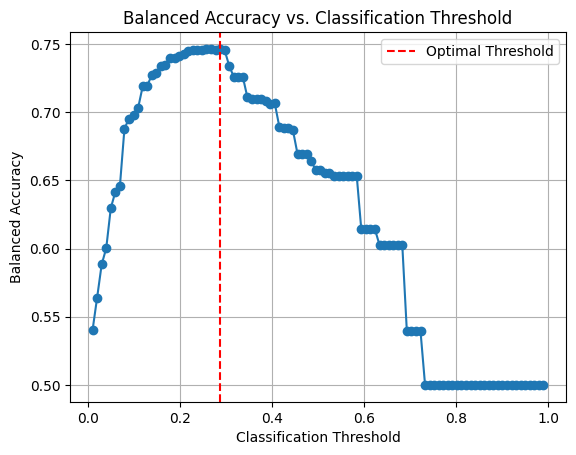

In [24]:
plt.plot(class_thresh_arr, ba_arr, marker='o', linestyle='-')
plt.title('Balanced Accuracy vs. Classification Threshold')
plt.xlabel('Classification Threshold')
plt.ylabel('Balanced Accuracy')
plt.axvline(x=best_class_thresh, color='r', linestyle='--', label='Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Predictions from Original Testing Data

we will now evaluate the logistic regression model on the original test data using various classification thresholds. We will compute several fairness metrics to understand the model's performance and bias at different thresholds.



In [25]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):

    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred,
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.2872


  0%|          | 0/100 [00:00<?, ?it/s]

Balanced accuracy = 0.7437
Statistical parity difference = -0.3580
Disparate impact = 0.2794
Average odds difference = -0.3181
Equal opportunity difference = -0.3769
Theil index = 0.1129


 47%|████▋     | 47/100 [00:00<00:00, 465.15it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 495.84it/s]


The results show the predictions from the original testing data using various classification thresholds. The optimal threshold and the corresponding fairness metrics are displayed, providing insight into the model's performance and bias.

This step helps us understand the impact of different classification thresholds on the model's fairness metrics, highlighting the trade-offs between accuracy and fairness.

### Visualizing Balanced Accuracy and Disparate Impact

we will visualize the relationship between the classification thresholds, balanced accuracy, and disparate impact. This helps us understand the trade-offs between accuracy and fairness across different thresholds.

This visualization shows how balanced accuracy and disparate impact change with different classification thresholds. The optimal threshold is marked with a vertical line, highlighting the point where the trade-off between accuracy and fairness is optimized.

Balanced Accuracy (Blue): Shows the model's accuracy across different thresholds.
Disparate Impact (Red): Indicates the fairness of the model, with lower values representing less bias.

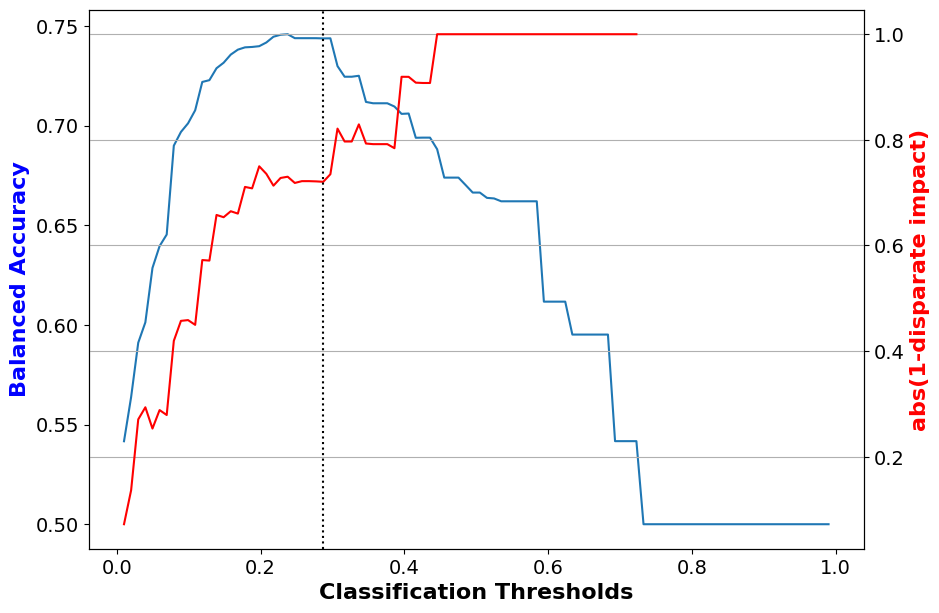

In [26]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Visualizing Balanced Accuracy and Average Odds Difference

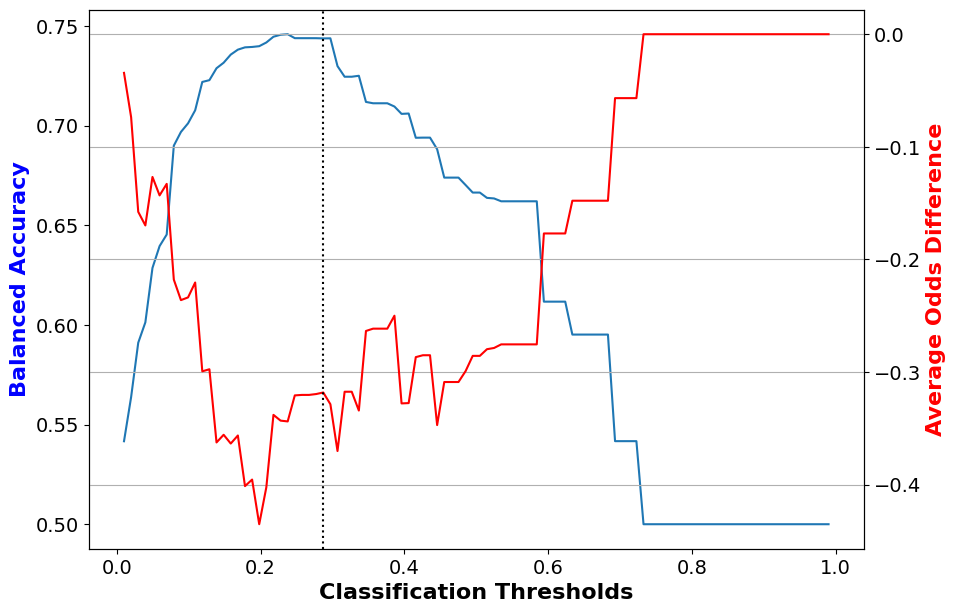

In [27]:
# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10,7))

# Plot balanced accuracy against classification thresholds on the primary axis
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

# Create a secondary axis to plot average odds difference
ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('Average Odds Difference', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.show()

## Training the Classifier on Transformed Data

we will now train a logistic regression classifier on the transformed training data, which has been reweighted to mitigate bias. This process helps us evaluate the effectiveness of the bias mitigation algorithm on the model's performance.


In [28]:
# Train classifier on transformed data
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

## Preparing the Transformed Test Dataset for Evaluation

We will now also prepare the transformed test dataset for evaluation by applying the logistic regression model trained on the transformed training data. This allows us to assess the model's performance on test data that has been reweighted to mitigate bias.

In [29]:
# Prepare transformed test dataset for evaluation
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)  # Create a deep copy of the original test dataset

# Standardize the features of the copied test dataset using the same scaler as used during training
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)

# Extract labels from the copied test dataset
y_test = dataset_transf_test_pred.labels

# Predict scores (probabilities) for the positive class using the logistic regression model trained on the transformed training data
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

## Predictions from Transformed Testing Data

In this section, we evaluate the logistic regression model on the transformed test data using various classification thresholds. We compute several fairness metrics to understand the model's performance and bias at different thresholds after applying the reweighting algorithm.

In [31]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):

    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred,
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.2872


 42%|████▏     | 42/100 [00:00<00:00, 412.31it/s]

Balanced accuracy = 0.7134
Statistical parity difference = -0.0705
Disparate impact = 0.7785
Average odds difference = 0.0188
Equal opportunity difference = 0.0293
Theil index = 0.1401


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 484.21it/s]


## Visualizing Balanced Accuracy and Disparate Impact for Transformed Data

In this section, we visualize the relationship between the classification thresholds, balanced accuracy, and disparate impact for the transformed test data. This helps us understand the trade-offs between accuracy and fairness after applying the reweighting algorithm.

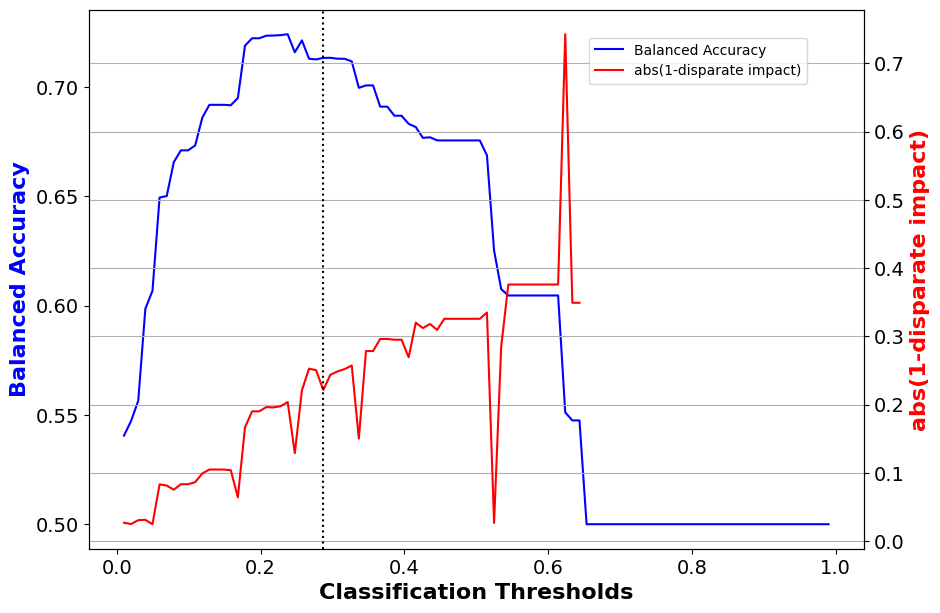

In [32]:
fig, ax1 = plt.subplots(figsize=(10,7))

# Plot balanced accuracy
ax1.plot(class_thresh_arr, bal_acc_arr_transf, label='Balanced Accuracy', color='b')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

# Create a twin Axes sharing the same x-axis
ax2 = ax1.twinx()

# Plot absolute difference of 1 and disparate impact
ax2.plot(class_thresh_arr, np.abs(1.0 - np.array(disp_imp_arr_transf)), label='abs(1-disparate impact)', color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')  # Mark the best classification threshold
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))

plt.show()

## Visualizing Balanced Accuracy and Average Odds Difference for Transformed Data

We want to visualize the relationship between the classification thresholds and two important metrics: balanced accuracy and average odds difference.

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

This visualization shows how balanced accuracy and average odds difference change with different classification thresholds for the transformed data. The optimal threshold is marked with a vertical line, highlighting the point where the trade-off between accuracy and fairness is optimized.

Balanced Accuracy (Blue): Shows the model's accuracy across different thresholds.
Average Odds Difference (Red): Indicates the fairness of the model, with lower values representing less bias.
This plot helps us visually assess the performance and fairness of the model on transformed data, providing a clear understanding of the impact of different classification thresholds after applying the bias mitigation algorithm.

### Conclusion

In this notebook, we explored the process of detecting and mitigating bias in machine learning models using the AIF360 toolkit. We applied the following steps to ensure a fair evaluation of our model:

1. **Data Preparation:**
   - Loaded and preprocessed datasets with protected attributes.
   - Split the data into training, validation, and test sets.

2. **Bias Detection:**
   - Calculated initial fairness metrics to identify bias in the original dataset.
   
3. **Bias Mitigation:**
   - Applied the Reweighing algorithm to mitigate bias in the training dataset.
   - Verified the effectiveness of the reweighting process through consistency checks.

4. **Model Training:**
   - Trained a logistic regression model on both the original and transformed training datasets.
   - Evaluated the model's performance on validation and test sets.

5. **Performance and Fairness Evaluation:**
   - Compared fairness metrics before and after bias mitigation.
   - Visualized the trade-offs between accuracy and fairness across different classification thresholds.

### Key Findings
- **Initial Bias:** The original dataset exhibited significant bias, as indicated by the difference in mean outcomes between unprivileged and privileged groups.
- **Effectiveness of Reweighing:** The Reweighing algorithm successfully mitigated bias, resulting in a difference in mean outcomes close to zero.
- **Optimal Thresholds:** We identified optimal classification thresholds that balance accuracy and fairness, both before and after reweighting.
- **Visual Insights:** Visualizations of balanced accuracy and disparate impact provided clear insights into the trade-offs between model performance and fairness.

### Future Work
To further enhance fairness and model performance, consider the following steps:
- **Additional Mitigation Techniques:** Explore other bias mitigation techniques such as Disparate Impact Remover, Optimized Preprocessing, or Adversarial Debiasing.
- **Model Diversity:** Test different machine learning models to assess their robustness and fairness.
- **Continuous Monitoring:** Implement continuous monitoring of fairness metrics in production to ensure sustained model fairness.

By systematically addressing bias and evaluating fairness, we can build more equitable and trustworthy machine learning models that perform well across diverse populations.

### References
- [AIF360 Toolkit Documentation](https://aif360.mybluemix.net/)
- [Scikit-Learn Documentation](https://scikit-learn.org/stable/documentation.html)
- [LIME Documentation](https://github.com/marcotcr/lime)

Thank you for following along with this notebook. If you have any questions or feedback, feel free to reach out. Happy modeling!
